In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

plt.rcParams["figure.figsize"] = (12, 6)
sns.set_theme(style="whitegrid", palette="pastel")

# Comparacion de Resultados GRD y DEIS

En este cuadernillo se quieren calcular las diferencias entre las bases de egresos hospitalarios GRD y DEIS. Se compararán:

1. Cantidad de egresos hospitalarios
2. Ranking para cada uno de los diagnósticos

Este análisis se realizará a nivel Nacional y a nivel del Hospital del Tórax

In [3]:
# Lee ranking de egresos DEIS
ranking_egresos_nacionales_deis = pl.read_csv(
    "../data/external/ranking_nacional_egresos.csv", encoding="latin-1", separator=";"
).to_pandas()

# Solo deja los estblecimientos publicos en DEIS
ranking_egresos_publicos_deis = ranking_egresos_nacionales_deis.dropna(
    subset="ranking_publicos_n_egresos"
).copy()

# Lee ranking de egresos GRD
ranking_egresos_nacionales_grd = pl.read_csv(
    "../data/interim/ranking_nacionales_egresos_grd.csv", separator=";"
).to_pandas()

In [4]:
# Define columnas a analizar entre ambas bases
COLUMNAS_A_SELECCIONAR = [
    "ANIO_EGRESO",
    "COD_HOSPITAL",
    "DIAGNOSTICO1",
    "Capítulo",
    "Sección",
    "Categoría",
    "Descripción",
    "GLOSA_ESTABLECIMIENTO_SALUD",
    "n_egresos_GRD",
    "n_egresos_DEIS",
    "ranking_egresos",
    "ranking_grd_n_egresos",
    "dias_estada_totales_GRD",
    "dias_estada_totales_DEIS",
    "ranking_nacionales_n_egresos",
    "ranking_publicos_n_egresos",
]

# Une ambas bases de datos segun el anio, hospital y diagnostico principal
comparacion_grd_deis_pais = (
    ranking_egresos_nacionales_grd.merge(
        ranking_egresos_nacionales_deis,
        left_on=["ANIO_EGRESO", "COD_HOSPITAL", "DIAGNOSTICO1"],
        right_on=["ANO_EGRESO", "ESTABLECIMIENTO_SALUD", "DIAG1"],
        how="inner",
        suffixes=("_GRD", "_DEIS"),
    )[COLUMNAS_A_SELECCIONAR]
)

# Obtiene comparacion de egresos solamente para el Torax
comparacion_grd_deis_torax = comparacion_grd_deis_pais.query("COD_HOSPITAL == 112103").copy()

In [5]:
DIFERENCIAS_A_CALCULAR = [
    ("n_egresos_GRD", "n_egresos_DEIS"),
    ("ranking_egresos", "ranking_grd_n_egresos"),
]

# Calcula diferencias entre egresos y rankings a nivel pais y Torax
comparacion_grd_deis_torax = build_features.calculate_and_add_difference(
    comparacion_grd_deis_torax, DIFERENCIAS_A_CALCULAR
)

comparacion_grd_deis_pais = build_features.calculate_and_add_difference(
    comparacion_grd_deis_pais, DIFERENCIAS_A_CALCULAR
)

In [6]:
# Obtiene el promedio de las diferencias de egresos
diferencia_promedio_egresos_torax = comparacion_grd_deis_torax[
    "n_egresos_GRD_n_egresos_DEIS_difference"
].mean()

# Obtiene el promedio de las diferencias de rankings
diferencia_promedio_ranking_torax = comparacion_grd_deis_torax[
    "ranking_egresos_ranking_grd_n_egresos_difference"
].mean()

print(f"> {diferencia_promedio_egresos_torax=:.2f} egresos")
print(f"> {diferencia_promedio_ranking_torax=:.2f} posiciones")

> diferencia_promedio_egresos_torax=3.08 egresos
> diferencia_promedio_ranking_torax=4.46 posiciones


In [7]:
# Obtiene el promedio de las diferencias de egresos
diferencia_promedio_egresos_pais = comparacion_grd_deis_pais[
    "n_egresos_GRD_n_egresos_DEIS_difference"
].mean()

# Obtiene el promedio de las diferencias de rankings
diferencia_promedio_ranking_pais = comparacion_grd_deis_pais[
    "ranking_egresos_ranking_grd_n_egresos_difference"
].mean()

print(f"> {diferencia_promedio_egresos_pais=:.2f} egresos")
print(f"> {diferencia_promedio_ranking_pais=:.2f} posiciones")

> diferencia_promedio_egresos_pais=6.95 egresos
> diferencia_promedio_ranking_pais=6.14 posiciones


# Diferencias en cantidad de Hospitales presentes

In [8]:
cantidad_hospitales_totales_deis = (
    ranking_egresos_nacionales_deis.groupby("ANO_EGRESO")["ESTABLECIMIENTO_SALUD"]
    .nunique()
    .to_frame()
)

cantidad_hospitales_publicos_deis = (
    ranking_egresos_publicos_deis.groupby("ANO_EGRESO")["ESTABLECIMIENTO_SALUD"]
    .nunique()
    .to_frame()
)

cantidad_hospitales_grd = (
    ranking_egresos_nacionales_grd.groupby("ANIO_EGRESO")["COD_HOSPITAL"].nunique().to_frame()
)

In [17]:
comparacion_cantidad_de_hospitales = pd.concat(
    [cantidad_hospitales_totales_deis, cantidad_hospitales_publicos_deis, cantidad_hospitales_grd],
    axis=1,
).dropna()

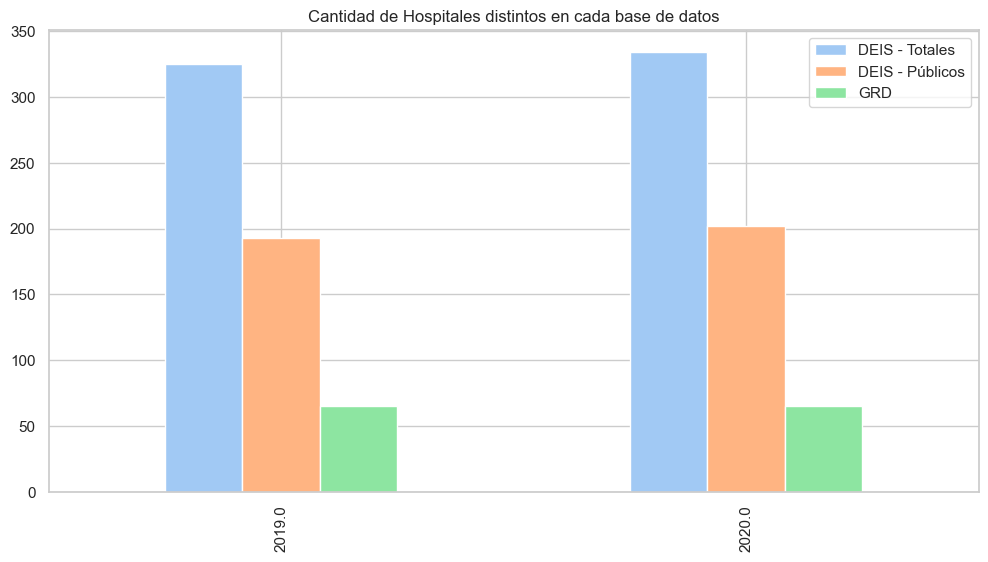

In [18]:
axis = comparacion_cantidad_de_hospitales.plot(kind="bar")
axis.legend(labels=["DEIS - Totales", "DEIS - Públicos", "GRD"])
plt.title("Cantidad de Hospitales distintos en cada base de datos")
plt.show()

# Diferencias en cantidad de Egresos Hospitalarios

Observando que DEIS Público contiene una mayor cantidad de recntos hospitalarios que GRD, es esperable que el primer contenga mayor cantidad de egresos hospitalarios. Debido a esto, sólamente se compararán los recintos hospitalarios que estén en ambas bases de datos.

In [25]:
# Calcula egresos para cada base de datos
egresos_nacionales_deis = ranking_egresos_nacionales_deis.groupby("ANO_EGRESO")["n_egresos"].sum()
egresos_publicos_deis = ranking_egresos_publicos_deis.groupby("ANO_EGRESO")["n_egresos"].sum()
egresos_grd = ranking_egresos_nacionales_grd.groupby("ANIO_EGRESO")["n_egresos"].sum()

# Une el calculo de egresos
comparacion_egresos = pd.concat(
    [egresos_nacionales_deis, egresos_publicos_deis, egresos_grd], axis=1
).dropna()

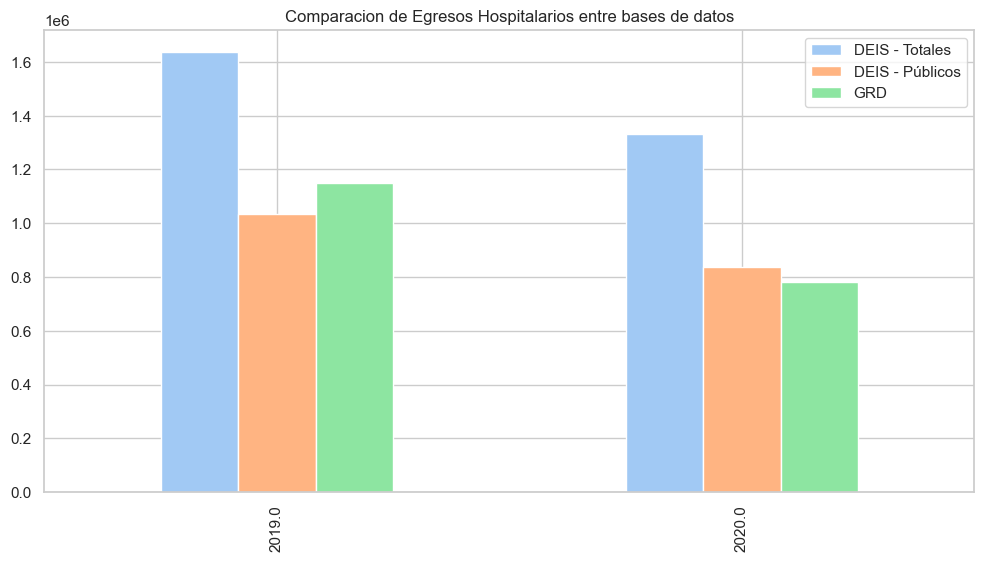

In [26]:
axis = comparacion_egresos.plot(kind="bar")
axis.legend(["DEIS - Totales", "DEIS - Públicos", "GRD"])
plt.title("Comparacion de Egresos Hospitalarios entre bases de datos")
plt.show()